Dataset Columns: Index(['PATIENT_ID', 'DATE', 'DURATION', 'PERDAY', 'CATEGORY', 'CATEGORY_L1',
       'CATEGORY_L2'],
      dtype='object')


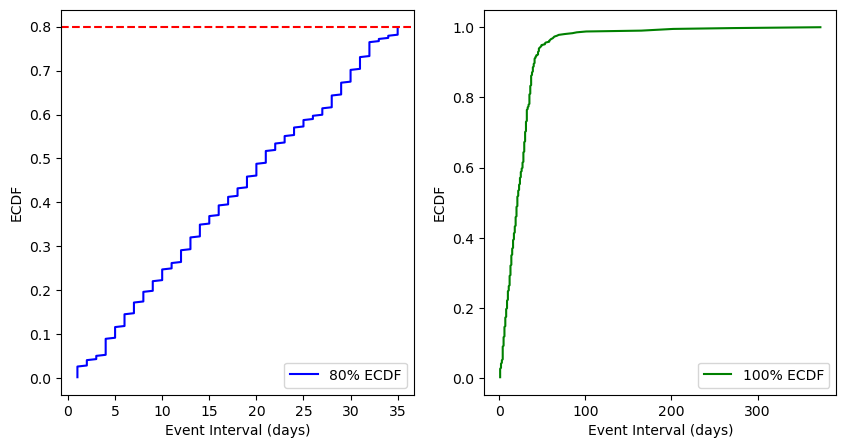

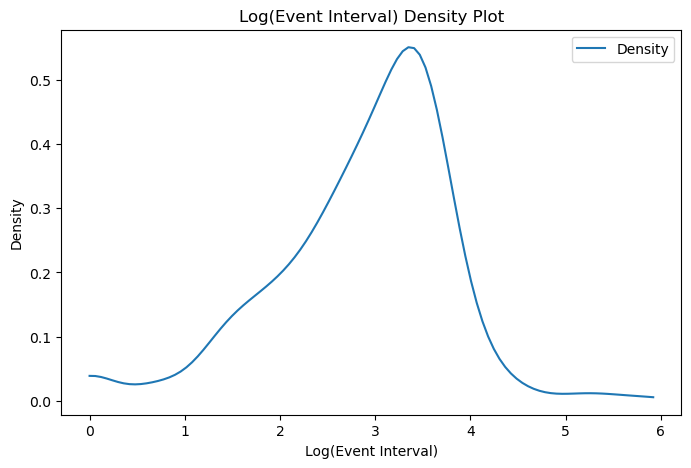

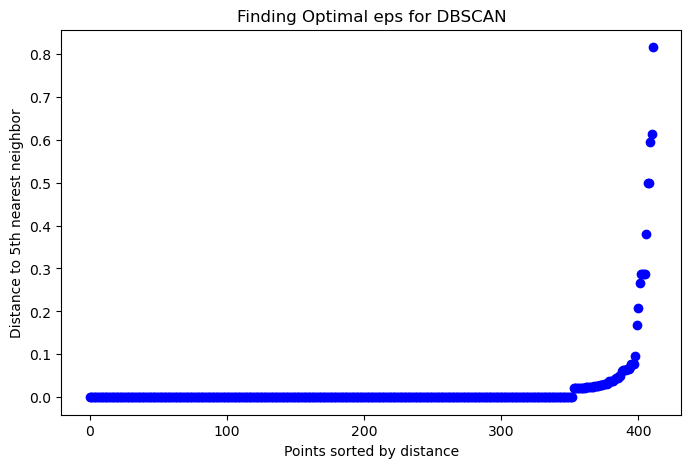

Estimated eps value: 0.5
Number of clusters found: 2
Number of noise points: 0
Silhouette Score for DBSCAN: 0.6494
                count       mean        std  min   25%   50%   75%    max
dbscan_cluster                                                           
0               401.0  25.977556  29.515453  2.0  12.0  21.0  32.0  373.0
1                11.0   1.000000   0.000000  1.0   1.0   1.0   1.0    1.0


D:\Users\fbasi\anaconda3\Lib\site-packages\seaborn\categorical.py:700: PendingDeprecationWarning: vert: bool will be deprecated in a future version. Use orientation: {'vertical', 'horizontal'} instead.
  artists = ax.bxp(**boxplot_kws)


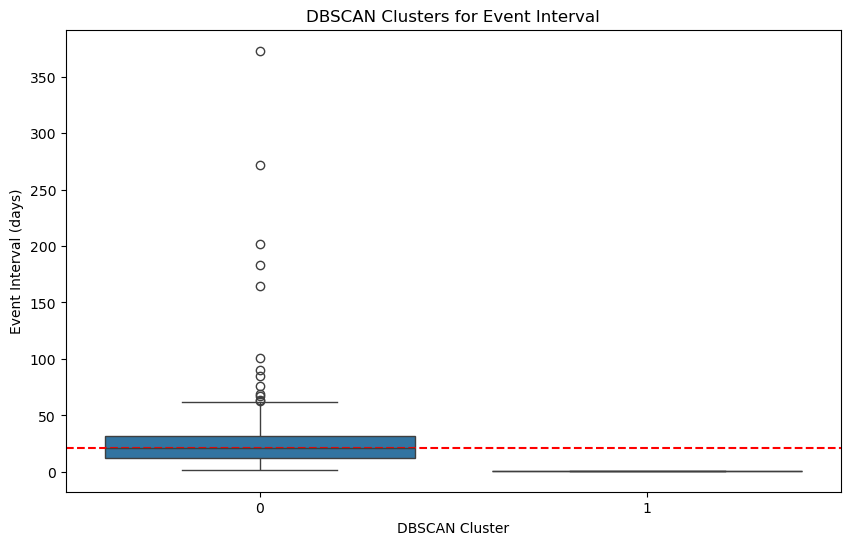

C:\Users\fbasi\AppData\Local\Temp\ipykernel_12388\2652278693.py:120: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=data['dbscan_cluster'], palette="viridis")


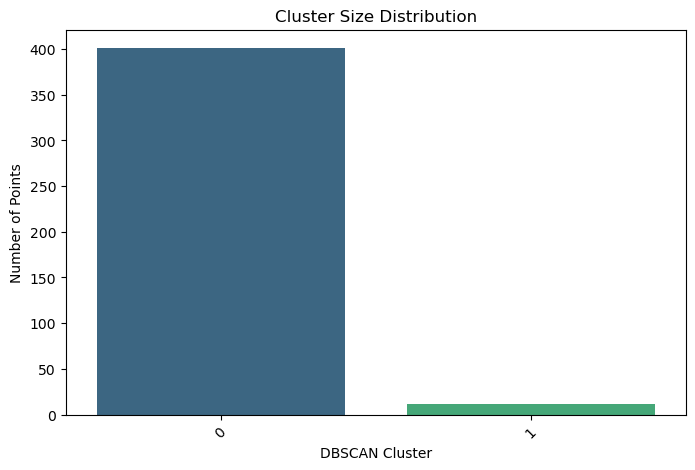

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import gaussian_kde
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score
import warnings
warnings.simplefilter("always")


# Load the dataset (update with actual file path)
data = pd.read_csv('C:/Users/fbasi/Desktop/ANALYTICS/SEE/med_events.csv')

# Check column names
print("Dataset Columns:", data.columns)

# Rename columns if necessary
data.rename(columns={'DATE': 'eksd', 'PATIENT_ID': 'pnr'}, inplace=True)

# Data Preprocessing
data['eksd'] = pd.to_datetime(data['eksd'])
data = data.sort_values(by=['pnr', 'eksd'])
data['prev_eksd'] = data.groupby('pnr')['eksd'].shift(1)
data = data.dropna()
data['event_interval'] = (data['eksd'] - data['prev_eksd']).dt.days
data = data[data['event_interval'] > 0]  # Ensure no zero or negative intervals

# ECDF Calculation
def ecdf(data):
    x = np.sort(data)
    y = np.arange(1, len(x)+1) / len(x)
    return x, y

x, y = ecdf(data['event_interval'])
df_ecdf = pd.DataFrame({'x': x, 'y': y})
df_ecdf = df_ecdf[df_ecdf['y'] <= 0.8]

# Plot ECDF
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(df_ecdf['x'], df_ecdf['y'], label='80% ECDF', color='blue')
plt.axhline(y=0.8, linestyle='dashed', color='red')
plt.xlabel("Event Interval (days)")
plt.ylabel("ECDF")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(x, y, label='100% ECDF', color='green')
plt.xlabel("Event Interval (days)")
plt.ylabel("ECDF")
plt.legend()
plt.show()

# Density Plot
density = gaussian_kde(np.log(data['event_interval']))
x_vals = np.linspace(min(np.log(data['event_interval'])), max(np.log(data['event_interval'])), 100)
y_vals = density(x_vals)
plt.figure(figsize=(8, 5))
plt.plot(x_vals, y_vals, label="Density")
plt.title("Log(Event Interval) Density Plot")
plt.xlabel("Log(Event Interval)")
plt.ylabel("Density")
plt.legend()
plt.show()

# Finding Optimal eps for DBSCAN using k-distance plot
scaled_data = np.log(data[['event_interval']])
neighbors = NearestNeighbors(n_neighbors=5)
neighbors_fit = neighbors.fit(scaled_data)
distances, indices = neighbors_fit.kneighbors(scaled_data)
distances = np.sort(distances[:, -1])

plt.figure(figsize=(8, 5))
plt.plot(distances, marker='o', linestyle='', color='b')
plt.xlabel("Points sorted by distance")
plt.ylabel("Distance to 5th nearest neighbor")
plt.title("Finding Optimal eps for DBSCAN")
plt.show()

# **Set eps based on the elbow point (default: 0.5)**
eps_value = 0.5  # Adjust based on the elbow plot

# Apply DBSCAN
dbscan = DBSCAN(eps=eps_value, min_samples=5)
data['dbscan_cluster'] = dbscan.fit_predict(scaled_data)

# Count the number of clusters and noise points
num_clusters = len(set(data['dbscan_cluster'])) - (1 if -1 in data['dbscan_cluster'] else 0)
num_noise = (data['dbscan_cluster'] == -1).sum()

print(f"Estimated eps value: {eps_value}")
print(f"Number of clusters found: {num_clusters}")
print(f"Number of noise points: {num_noise}")

# Compute silhouette score (ignoring noise points)
valid_clusters = data['dbscan_cluster'] != -1
if num_clusters > 1:
    silhouette_avg = silhouette_score(scaled_data[valid_clusters], data.loc[valid_clusters, 'dbscan_cluster'])
    print(f"Silhouette Score for DBSCAN: {silhouette_avg:.4f}")
else:
    print("Silhouette Score not available (only one cluster found)")

# Event Interval per Cluster
cluster_event_intervals = data.groupby('dbscan_cluster')['event_interval'].describe()
print(cluster_event_intervals)

# Visualizing DBSCAN Clusters
plt.figure(figsize=(10, 6))
sns.boxplot(x=data['dbscan_cluster'], y=data['event_interval'])
plt.axhline(y=np.median(data['event_interval']), color='red', linestyle='dashed')
plt.xlabel("DBSCAN Cluster")
plt.ylabel("Event Interval (days)")
plt.title('DBSCAN Clusters for Event Interval')
plt.show()

# Cluster Size Distribution
plt.figure(figsize=(8, 5))
sns.countplot(x=data['dbscan_cluster'], palette="viridis")
plt.xlabel("DBSCAN Cluster")
plt.ylabel("Number of Points")
plt.title("Cluster Size Distribution")
plt.xticks(rotation=45)
plt.show()
